In [1]:
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import numpy as np 
import pickle
from numpy import pi
import operator
import deap.benchmarks.tools as bt
import pandas as pd

creator.create("obj", base.Fitness, weights=(-1.0,-1.0, -1.0))
creator.create("Ind", list, fitness=creator.obj)

In [2]:
checkpoint_file = "checkpoint.pkl"
with open(checkpoint_file, "rb") as cp_file:
    cp = pickle.load(cp_file)

In [3]:
cp["input_file"]

{'control_variables': {'pf': {'min': 0.02, 'max': 0.06},
  'sine_a': {'min': 0.0, 'max': 2.0},
  'sine_b': {'min': 0.0, 'max': 1.57},
  'sine_c': {'min': 0.0, 'max': 6.28}},
 'evaluators': {'openmc_gc': {'order': 0,
   'input_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_plank_openmc.py'],
   'execute2': [['aprun -n 1 -d 64 --env OMP_NUM_THREADS=64 openmc-0.12.2'],
    ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ../../../../moltres/python/moltres_xs.py',
     'fhr_plank_gc.inp']],
   'inputs': ['pf', 'sine_a', 'sine_b', 'sine_c'],
   'output_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_plank_openmc_output.py'],
   'outputs': ['pf', 'keff2', 'ppf'],
   'keep_files': 'all'},
  'moltres': {'order': 1,
   'input_script': ['aprun -n 6 -N 6 -d 1 -j 1 moltres-opt -i ',
    'fhr_plank_moltres.i'],
   'execute2': [],
   'inputs': [],
   'output_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_plank_moltres_output.py'],
 

In [4]:
def get_ind_list(pop_list, index):
    ind_list = [] 
    for pop in pop_list:
        ind_list.append(pop[index])
    return ind_list

In [5]:
def plot_1_obj(logbook, index, obj_name, short_name, save_fig, save_fig_title):
    gen = logbook.select("gen")
    obj_avg = get_ind_list(logbook.chapters["oup"].select("avg"), index)
    obj_std = get_ind_list(logbook.chapters["oup"].select("std"), index)
    obj_min = get_ind_list(logbook.chapters["oup"].select("min"), index)
    obj_max = get_ind_list(logbook.chapters["oup"].select("max"), index)
    plt.rc('font', family='serif')
    fig, ax = plt.subplots(figsize=(15,7))
    ax.errorbar(gen, obj_avg, yerr=obj_std, label="Ave "+ short_name, capsize=5)
    ax.plot(gen, obj_min, "*-", label="Min "+ short_name)
    ax.plot(gen, obj_max, "*-", label="Max "+ short_name)
    ax.set_xlabel("Generation", fontsize=20)
    ax.set_ylabel(obj_name, fontsize=20)
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 1.0])
    ax.set_title(obj_name + " Evolution", fontsize=20)
    if save_fig:
        plt.savefig(save_fig_title,bbox_inches='tight')

In [6]:
logbook = cp["logbook"]

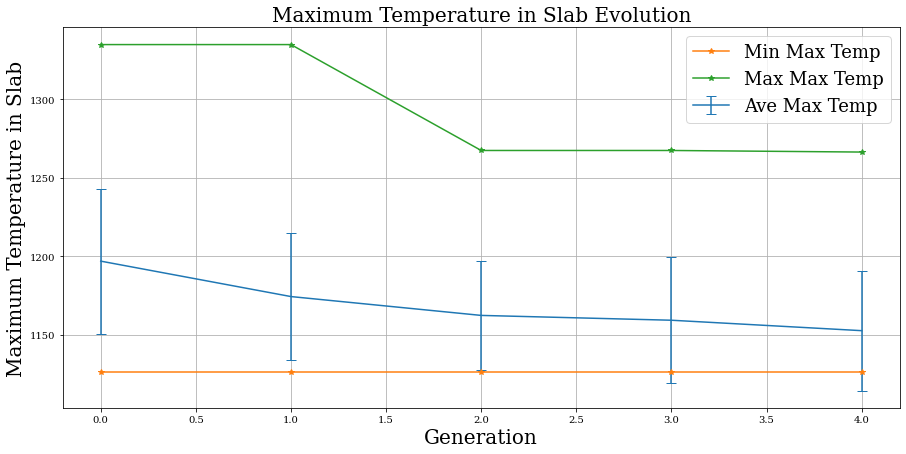

In [7]:
plot_1_obj(logbook, 1, "Maximum Temperature in Slab", "Max Temp", False, "slab-obj-3-temp-evol.png")

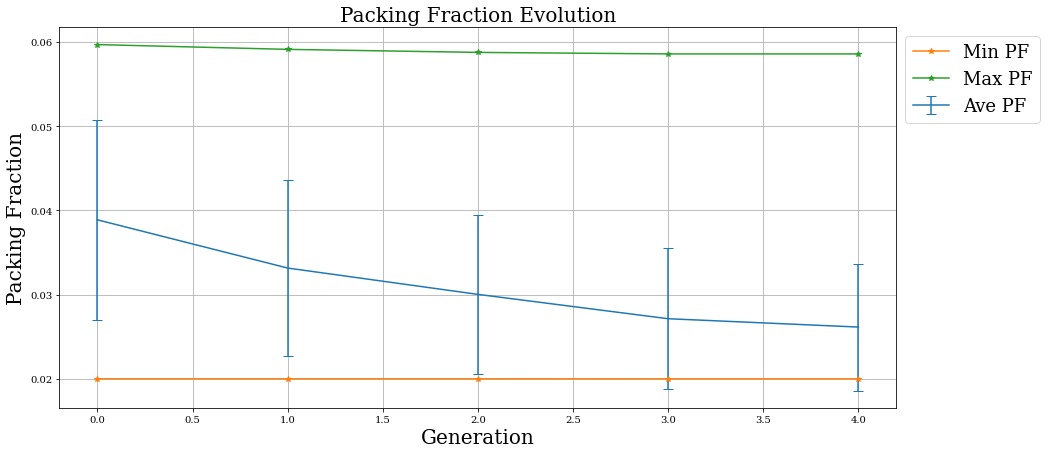

In [8]:
plot_1_obj(logbook, 0, "Packing Fraction", "PF", False, "slab-obj-3-pf-evol.png")

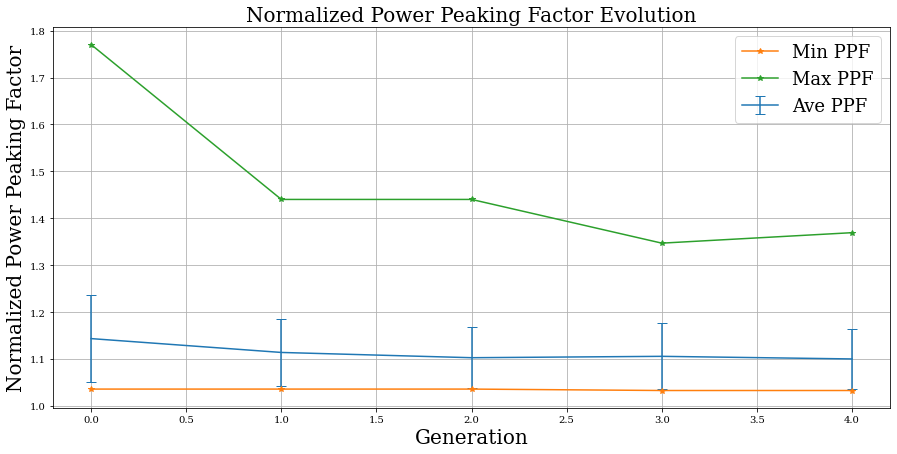

In [9]:
plot_1_obj(logbook, 2, "Normalized Power Peaking Factor", "PPF", False, "slab-obj-3-ppf-evol.png")

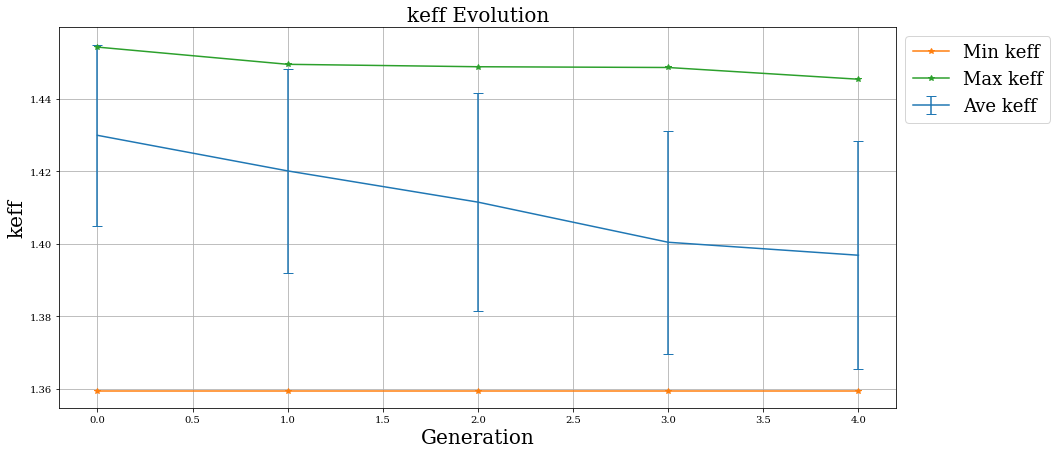

In [10]:
plot_1_obj(logbook, 3, "keff", "keff", False, "")

In [11]:
def sine_curve(ind, pf_present):
    if pf_present:
        pf, a, b, c = ind[0], ind[1], ind[2], ind[3]
    else:
        a, b, c = ind[0], ind[1], ind[2]
        pf = 0.0979
    boundaries = np.arange(2,27.1,2.31)
    midpoints = [] 
    for x in range(len(boundaries)-1):
        midpoints.append((boundaries[x]+boundaries[x+1])/2)
    midpoints = np.array(midpoints)
    x = midpoints
    x1 = np.arange(2, 24.8, 0.01)
    T_pitch = 0.09266
    vol_total = 23.1 * 2.55 * T_pitch * 20
    vol_triso = 4 / 3 * np.pi * 4235e-5 ** 3
    no_trisos = pf * vol_total / vol_triso
    vol_slice = 2.31 * 2.55 * T_pitch * 20
    sine = a * np.sin(b*x + c) + 2
    sine1 = a * np.sin(b*x1 + c) + 2
    sine1 = sine1 / sum(sine) * no_trisos * vol_triso / vol_slice
    sine = sine / sum(sine) * no_trisos * vol_triso / vol_slice
    return x, sine, x1, sine1 

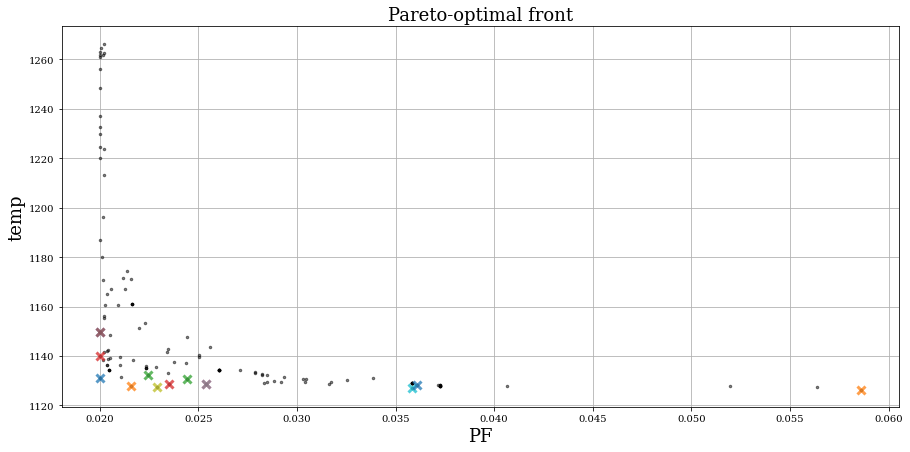

In [12]:
results = cp["all"]
all_pop = []
for p in results["populations"]:
    for i in p:
        all_pop.append(i)
pop = results["populations"][-1]
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
fig, ax = plt.subplots(figsize=(15,7))
for ind in pop:
    ax.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', ms=5, alpha=0.5)
for ind in non_dom:
    ax.plot(ind.fitness.values[0], ind.fitness.values[1], 'x', alpha=0.74, ms=8, mew=3)
#ax.set_xlim(0.01, 0.10)
#ax.set_ylim(1.0, 1.6)
ax.set_xlabel('PF',fontsize=18)
ax.set_ylabel('temp',fontsize=18)
ax.set_title('Pareto-optimal front',fontsize=18)
ax.grid()
#plt.savefig("slab-obj-2-pfppf-pareto",bbox_inches='tight')

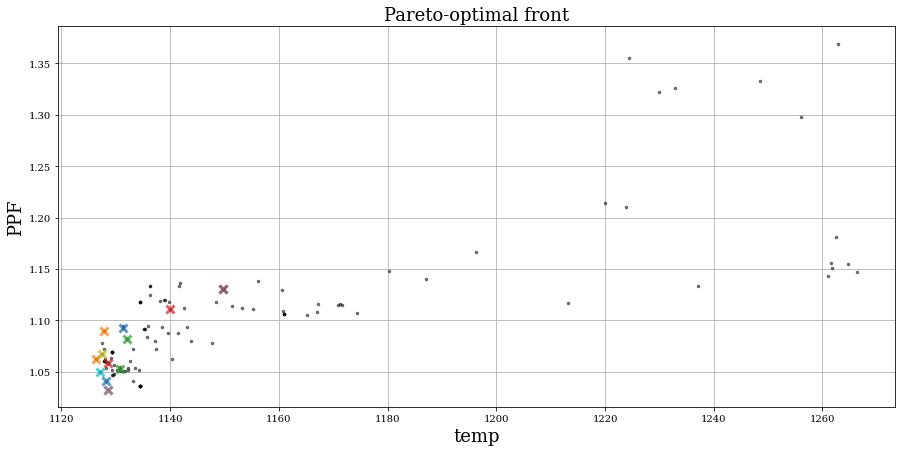

In [13]:
results = cp["all"]
pop = results["populations"][-1]
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
fig, ax = plt.subplots(figsize=(15,7))
for ind in pop:
    ax.plot(ind.fitness.values[1], ind.fitness.values[2], 'k.', ms=5, alpha=0.5)
for ind in non_dom:
    ax.plot(ind.fitness.values[1], ind.fitness.values[2], 'x', alpha=0.74, ms=8, mew=3)
#ax.set_xlim(0.01, 0.10)
#ax.set_ylim(1.0, 1.6)
ax.set_xlabel('temp',fontsize=18)
ax.set_ylabel('PPF',fontsize=18)
ax.set_title('Pareto-optimal front',fontsize=18)
ax.grid()
#plt.savefig("slab-obj-2-pfppf-pareto",bbox_inches='tight')

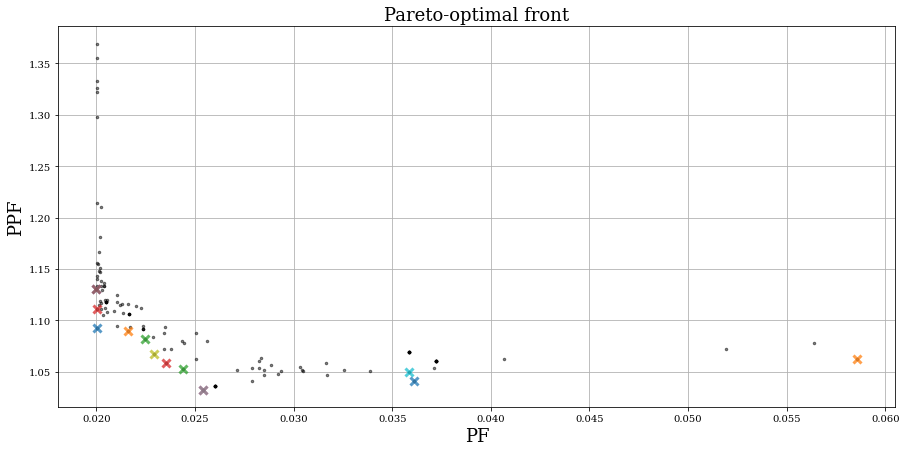

In [14]:
results = cp["all"]
pop = results["populations"][-1]
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
fig, ax = plt.subplots(figsize=(15,7))
for ind in pop:
    ax.plot(ind.fitness.values[0], ind.fitness.values[2], 'k.', ms=5, alpha=0.5)
for ind in non_dom:
    ax.plot(ind.fitness.values[0], ind.fitness.values[2], 'x', alpha=0.74, ms=8, mew=3)
#ax.set_xlim(0.01, 0.10)
#ax.set_ylim(1.0, 1.6)
ax.set_ylabel('PPF',fontsize=18)
ax.set_xlabel('PF',fontsize=18)
ax.set_title('Pareto-optimal front',fontsize=18)
ax.grid()
#plt.savefig("slab-obj-2-pfppf-pareto",bbox_inches='tight')

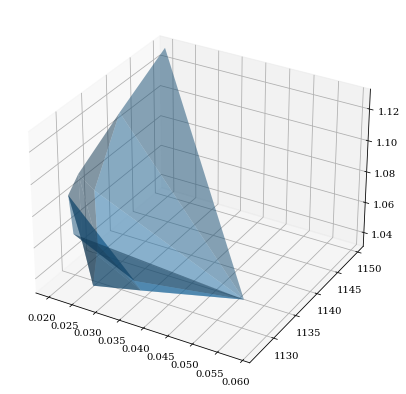

In [15]:
results = cp["all"]
pop = results["populations"][-1]
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
pf, temp, ppf = [], [], []
for ind in non_dom:
    pf.append(ind.fitness.values[0])
    temp.append(ind.fitness.values[1])
    ppf.append(ind.fitness.values[2])
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(projection='3d')
ax.plot_trisurf(pf, temp, ppf, alpha=0.5)

Text(0.5, 0.9384, "Final Generation's Pareto Front")

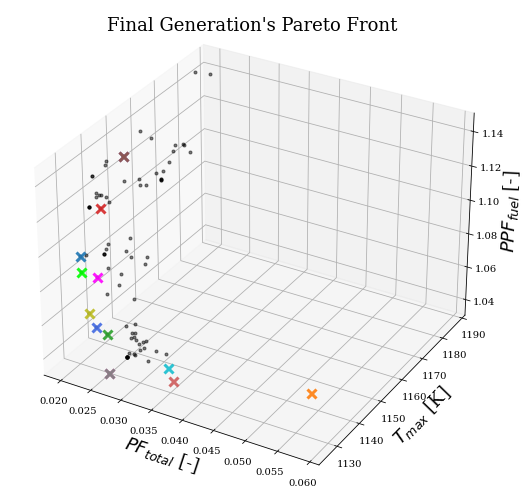

In [16]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "indianred", "lime", "magenta", "royalblue"]
results = cp["all"]
pop = results["populations"][-1]
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(projection='3d')
for ind in pop:
    if ind.fitness.values[0] < 0.035 and ind.fitness.values[1] < 1190 and ind.fitness.values[2] < 1.15:
        ax.plot(ind.fitness.values[0], ind.fitness.values[1], ind.fitness.values[2], 'k.', ms=6, alpha=0.5)
for i, ind in enumerate(non_dom):
    ax.plot(ind.fitness.values[0], ind.fitness.values[1], ind.fitness.values[2], 'x', alpha=0.9, ms=9, mew=3, color=colors[i])
#ax.legend()
ax.grid()
ax.set_xlabel('$PF_{total}$ [-]',fontsize=18)
ax.set_ylabel('$T_{max}$ [K]',fontsize=18)
ax.set_zlabel('$PPF_{fuel}$ [-]', fontsize=18)
ax.set_title("Final Generation's Pareto Front",fontsize=18, y=1.02)
#ax.set_xlim(0.02, 0.035)
#ax.set_xticks([0.02, 0.025, 0.03, 0.035])
#ax.set_ylim(1125, 1200)
#ax.set_yticks([1130, 1150, 1170, 1190])
#ax.set_zlim(1.0, 1.15)
#ax.set_zticks([1.0, 1.05, 1.1, 1.15])
#plt.savefig("slab-obj-3-3d.png",bbox_inches='tight')

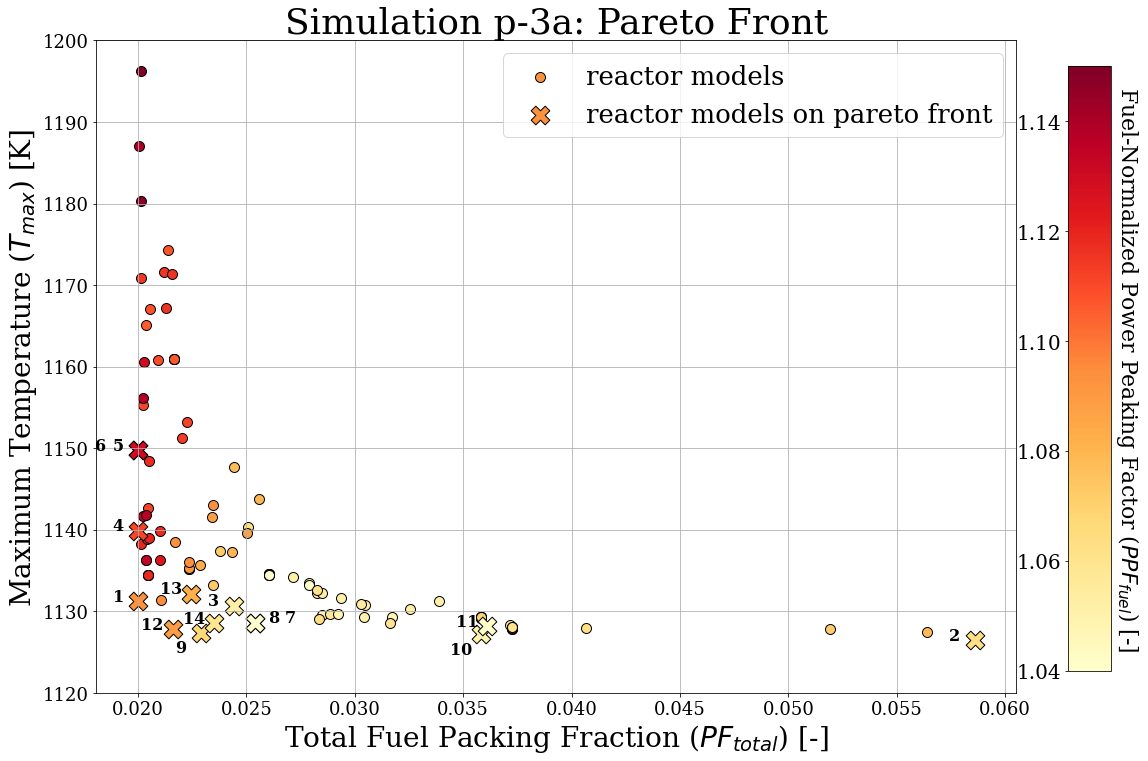

In [17]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "indianred", "lime", "magenta", "royalblue"]*2
results = cp["all"]
pop = results["populations"][-1]
final_non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
fig, ax = plt.subplots(figsize=(12, 12))
count1, count2 = 0, 0
for i, ind in enumerate(pop):
    if count1 == 0:
        ax.scatter(ind.fitness.values[0], ind.fitness.values[1], c=ind.fitness.values[2], vmin=1.04, vmax=1.15, 
                   cmap="YlOrRd", marker='o',edgecolors='black', alpha=1, s=100, label="reactor models")
        count1 += 1
    else:
        ax.scatter(ind.fitness.values[0], ind.fitness.values[1], c=ind.fitness.values[2], vmin=1.04, vmax=1.15, 
                   cmap="YlOrRd", marker='o',edgecolors='black', alpha=1, s=100)
prev_0, prev_1 = 0, 0
num = 1
for i, ind in enumerate(final_non_dom):
    if count2 == 0:
        ax.scatter(ind.fitness.values[0], ind.fitness.values[1], c=ind.fitness.values[2], vmin=1.04, 
                   vmax=1.15, cmap="YlOrRd", marker="X", s=350, edgecolors='black', alpha=1, 
                   label="reactor models on pareto front")
        count2 += 1
    else:
        im = ax.scatter(ind.fitness.values[0], ind.fitness.values[1], c=ind.fitness.values[2], vmin=1.04, 
                    vmax=1.15, cmap="YlOrRd", marker="X", s=350, edgecolors='black', alpha=1)
    if num < 100:
        offset_0, offset_1 = abs(ind.output[0]-prev_0), abs(ind.output[1]-prev_1)
        offset_y = 0
        if offset_0 < 0.002 and offset_1 < 0.01:
            if num < 10:
                offset_x -= 17
            else:
                offset_x -= 25
        else:
            offset_x = -20
        if num in [7]:
            offset_x = 35
        if num in [9, 10]:
            offset_y = -20
        ax.annotate(str(num), (ind.output[0], ind.output[1]), textcoords="offset points", 
                    xytext=(offset_x,offset_y), ha='center', weight='bold', fontsize=16) 
        prev_0, prev_1 = ind.output[0], ind.output[1]
    num += 1
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=26, bbox_to_anchor = [1.0, 1.0])
ax.tick_params(axis='both', which='major', labelsize=18)
fig.subplots_adjust(right=1.19)
cbar_ax = fig.add_axes([1.25, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
cbar_ax.yaxis.set_ticks_position('left')
ax.set_ylim([1120, 1200])
ax.set_ylabel(r'Maximum Temperature ($T_{max}$) [K]',fontsize=28)
ax.set_xlabel(r'Total Fuel Packing Fraction ($PF_{total}$) [-]',fontsize=28)
cb.set_label(r'Fuel-Normalized Power Peaking Factor ($PPF_{fuel}$) [-]', fontsize=22, rotation=270, labelpad=30)
ax.set_title('Simulation p-3a: Pareto Front',fontsize=36)
plt.savefig("slab-obj-3-3d.png",bbox_inches='tight')


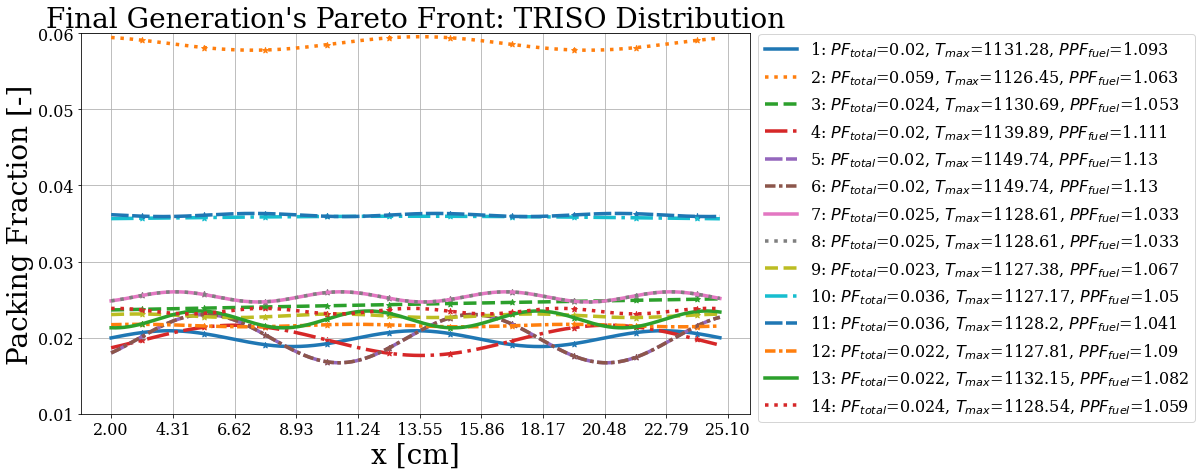

In [18]:
results = cp["all"]
pop = results["populations"][-1]
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
fig, ax = plt.subplots(figsize=(12,7))
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "tab:blue","tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
line_styles = 3*["-", ":", "--", "-.", (0, (5, 1)), (0, (3, 1, 1, 1))]
for i, ind in enumerate(non_dom):
    x, sine, x1, sine1 = sine_curve(ind, True)
    ax.scatter(x, sine, marker='*', color=colors[i])
    ax.plot(x1, sine1, alpha=1, linestyle=line_styles[i], color=colors[i], linewidth=3.5,
            label=str(i+1)+ ": $PF_{total}$="+str(round(ind.fitness.values[0],3))+", $T_{max}$="+str(round(ind.fitness.values[1],2))+", $PPF_{fuel}$="+str(round(ind.fitness.values[2],3)))
ax.grid()
ax.set_ylim(0.01,0.06)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=16, bbox_to_anchor = [1.0, 1.02])
ax.set_xticks(np.arange(2,27.1,2.31))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel("x [cm]", fontsize=28)
ax.set_ylabel("Packing Fraction [-]", fontsize=28)
ax.set_title("Final Generation's Pareto Front: TRISO Distribution", fontsize=28)
plt.savefig("slab-obj-3-distr.png",bbox_inches='tight')

4 1 6
1 gen 0 num 122 [0.058586841811095025, 0.030156351598429998, 0.5008994998956392, 1.0551664904014566]
fitness (0.058586841811095025, 1126.4492842474, 1.0627864483802707)
4 gen 3 num 2 [0.020000468318649024, 0.319007459330723, 0.6271646288192301, 4.393235330807894]
fitness (0.020000468318649024, 1149.7433738637, 1.1303789084705413)
6 gen 3 num 4 [0.025413157934195886, 0.052534450964591944, 1.0172720707376608, 3.359219821240229]
fitness (0.025413157934195886, 1128.6051658923, 1.0328323937360613)


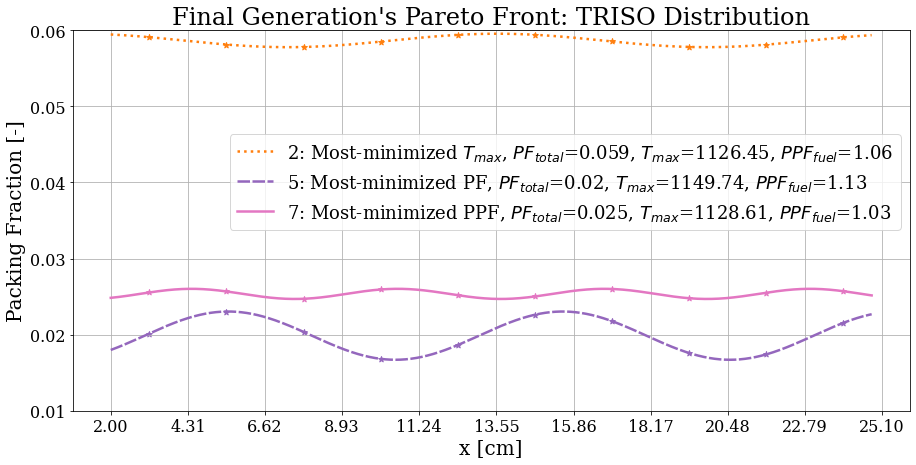

In [19]:
results = cp["all"]
pop = results["populations"][-1]
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
obj_0 = np.array([item.fitness.values[0] for item in non_dom])
obj_1 = np.array([item.fitness.values[1] for item in non_dom])
obj_2 = np.array([item.fitness.values[2] for item in non_dom])
pf_min = np.argsort(obj_0)[0]
temp_min = np.argsort(obj_1)[0]
ppf_min = np.argsort(obj_2)[0]
print(pf_min, temp_min, ppf_min)
fig, ax = plt.subplots(figsize=(15,7))
for i, ind in enumerate(non_dom):
    if i in [pf_min, temp_min, ppf_min]:
        print(i, "gen", ind.gen, "num", ind.num, ind)
        print("fitness", ind.fitness)
        x, sine, x1, sine1 = sine_curve(ind, True)
        ax.scatter(x, sine, marker='*', color=colors[i])
        label = str(i+1) + ": "
        if i == pf_min:
            label += "Most-minimized PF"
        if i == temp_min:
            label += "Most-minimized $T_{max}$"
        if i == ppf_min:
            label += "Most-minimized PPF"
        label += ", $PF_{total}$="+str(round(ind.fitness.values[0],3))+", $T_{max}$="+str(round(ind.fitness.values[1],2))+", $PPF_{fuel}$="+str(round(ind.fitness.values[2],2))
        ax.plot(x1, sine1, alpha=1, label=label, color=colors[i], linestyle=line_styles[i], linewidth=2.5)
ax.grid()
ax.set_ylim(0.01,0.06)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 0.75])
ax.set_xticks(np.arange(2,27.1,2.31))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel("x [cm]", fontsize=20)
ax.set_ylabel("Packing Fraction [-]", fontsize=20)
ax.set_title("Final Generation's Pareto Front: TRISO Distribution", fontsize=24)
plt.savefig("slab-obj-3-distr-most-minimized.png",bbox_inches='tight')

4 [ 1  9  8 11 10 13  6  7  2  0 12  3  4  5] 6
1 (0.058586841811095025, 1126.4492842474, 1.0627864483802707)
9 (0.03583731568448589, 1127.1656109388, 1.050114005260512)
8 (0.02289310649841443, 1127.3834042561, 1.0673783698575252)
11 (0.021592829880009694, 1127.8070512186, 1.0896676006576245)
10 (0.036104559661459264, 1128.1999706264, 1.0413305964584894)


Text(0.5, 1.0, "Final Generation's Pareto Front: TRISO Distribution")

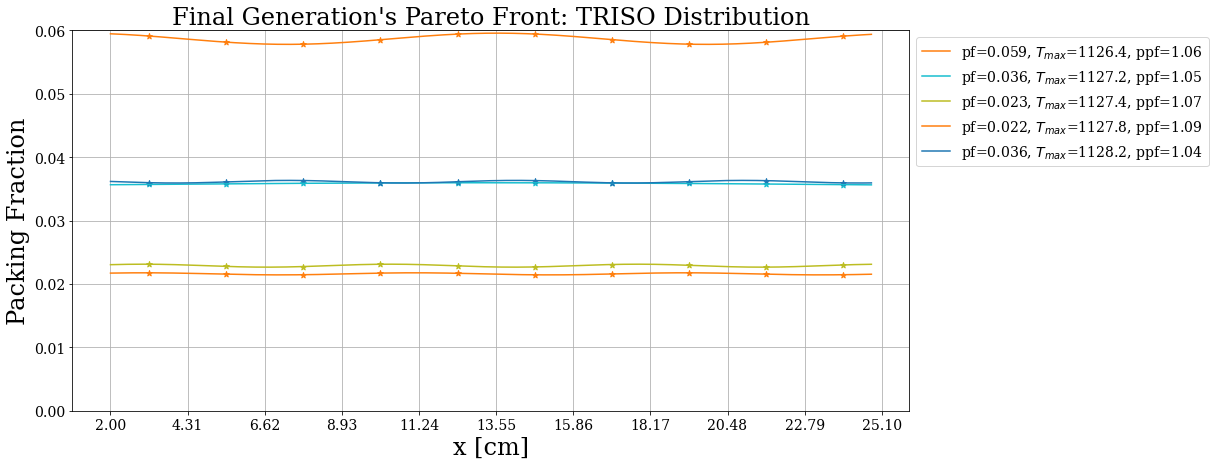

In [20]:
results = cp["all"]
pop = results["populations"][-1]
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
obj_0 = np.array([item.fitness.values[0] for item in non_dom])
obj_1 = np.array([item.fitness.values[1] for item in non_dom])
obj_2 = np.array([item.fitness.values[2] for item in non_dom])
pf_min = np.argsort(obj_0)[0]
temp_min = np.argsort(obj_1)
ppf_min = np.argsort(obj_2)[0]
print(pf_min, temp_min, ppf_min)
fig, ax = plt.subplots(figsize=(15,7))
for j, i in enumerate(temp_min):
    if j < 5:
        ind = non_dom[i]
        print(i, ind.fitness)
        x, sine, x1, sine1 = sine_curve(ind, True)
        ax.scatter(x, sine, marker='*', color=colors[i])
        label = "pf="+str(round(ind.fitness.values[0],3))+", $T_{max}$="+str(round(ind.fitness.values[1],1))+", ppf="+str(round(ind.fitness.values[2],2))
        ax.plot(x1, sine1, alpha=1, label=label, color=colors[i])
ax.grid()
ax.set_ylim(0,0.06)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14, bbox_to_anchor = [1.0, 1.0])
ax.set_xticks(np.arange(2,27.1,2.31))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel("x [cm]", fontsize=24)
ax.set_ylabel("Packing Fraction", fontsize=24)
ax.set_title("Final Generation's Pareto Front: TRISO Distribution", fontsize=24)

PF, TEMP, PPF 4 1 6
gen, num 0 124
PPF 1.0526933873832256
2 [0.02440859997970008, 1.8527140301100535, 0.007195432245984322, 0.7483880786843286]
fitness (0.02440859997970008, 1130.6906067085, 1.0526933873832256)
gen, num 3 4
PPF 1.0328323937360613
6 [0.025413157934195886, 0.052534450964591944, 1.0172720707376608, 3.359219821240229]
fitness (0.025413157934195886, 1128.6051658923, 1.0328323937360613)
gen, num 4 7
PPF 1.0328323937360613
7 [0.025413157934195886, 0.052534450964591944, 1.0172720707376608, 3.359219821240229]
fitness (0.025413157934195886, 1128.6051658923, 1.0328323937360613)
gen, num 3 16
PPF 1.050114005260512
9 [0.03583731568448589, 0.015581037835699085, 0.15167205798516575, 5.858830705381309]
fitness (0.03583731568448589, 1127.1656109388, 1.050114005260512)
gen, num 3 21
PPF 1.0413305964584894
10 [0.036104559661459264, 0.011366224299297501, 0.9217818581345597, 1.0979905323304424]
fitness (0.036104559661459264, 1128.1999706264, 1.0413305964584894)


Text(0.5, 1.0, "Final Generation's Pareto Front: TRISO Distribution")

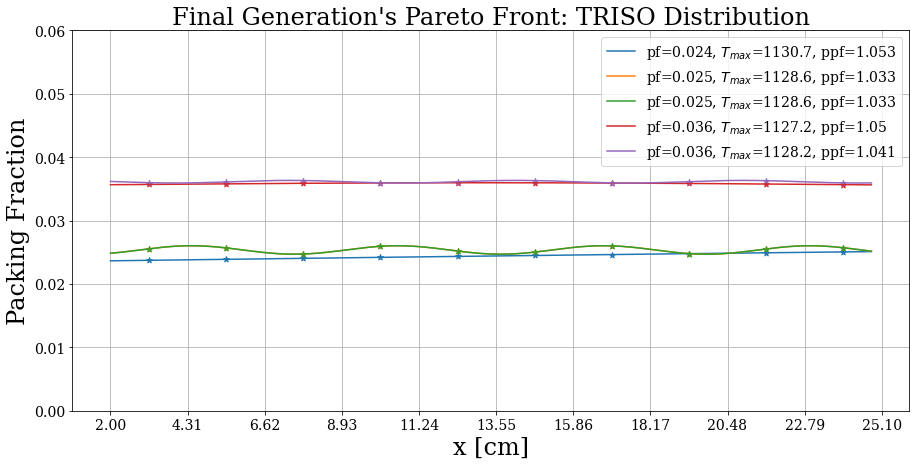

In [21]:
results = cp["all"]
pop = results["populations"][-1]
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
obj_0 = np.array([item.fitness.values[0] for item in non_dom])
obj_1 = np.array([item.fitness.values[1] for item in non_dom])
obj_2 = np.array([item.fitness.values[2] for item in non_dom])
pf_min = np.argsort(obj_0)[0]
temp_min = np.argsort(obj_1)[0]
ppf_min = np.argsort(obj_2)[0]
print("PF, TEMP, PPF", pf_min, temp_min, ppf_min)
fig, ax = plt.subplots(figsize=(15,7))
for i, ind in enumerate(non_dom):
    if i in np.argsort(obj_2)[:5]:
        print("gen, num", ind.gen, ind.num)
        print("PPF", obj_2[i])
        print(i, ind)
        print("fitness", ind.fitness)
        x, sine, x1, sine1 = sine_curve(ind, True)
        ax.scatter(x, sine, marker='*')
        label = "pf="+str(round(ind.fitness.values[0],3))+", $T_{max}$="+str(round(ind.fitness.values[1],1))+", ppf="+str(round(ind.fitness.values[2],3))
        ax.plot(x1, sine1, alpha=1, label=label)
ax.grid()
ax.set_ylim(0,0.06)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14, bbox_to_anchor = [1.0, 1.0])
ax.set_xticks(np.arange(2,27.1,2.31))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel("x [cm]", fontsize=24)
ax.set_ylabel("Packing Fraction", fontsize=24)
ax.set_title("Final Generation's Pareto Front: TRISO Distribution", fontsize=24)
#plt.savefig("slab-obj-3-distr-most-minimized-all.png",bbox_inches='tight')

In [22]:
results = cp["all"]
ref = np.array([0.06, 1260 ,1.5])
for pop in results["populations"]:
    non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
    hypervol = bt.hypervolume(non_dom, ref)
    print(hypervol)

2.3927980349217104
2.3927980349217104
2.3938340710767467
2.4427579331074445
2.4465409501317397
